# Imports

In [1]:
# import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
import package_LAB

from importlib import reload
package_DBR = reload (package_DBR)
package_LAB = reload(package_LAB)

from package_LAB import *
from package_DBR import *

# Simulation Parameters

In [ ]:
# Simulation Parameters
TSim = 2700
Ts=1
N = int(TSim/Ts)+1
alpha = 1 #0.27
MVMin = 0
MVMax = 100

# Working Point
MV0 = 50
PV0 = 52.5  # from previous experience
DV0 = 50


#--------Process------------
# In-Out Dynamics
Kp = 0.4
T1p = 150      # 83 est trop aggressif, choisir au moins 150
T2p = 110
thetap = 10

# Disturbance Dynamics
Kd = 0.34
T1d = 100
T2d = 35
thetad = 32

# Process Object
# P = Process({})
# P.parameters['Kp'] = Kp
# P.parameters['Tlead1'] = 0
# P.parameters['Tlag1'] = T1p
# P.parameters['Tlag2'] = T2p
# P.parameters['theta'] = thetaP
# P.parameters['nInt'] = 0


#----------Controller-----------
# C = Controller({})

# Tuning
gamma = 0.6
Kc, Ti, Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
# Kc = C.parameters['Kc']
# Ti = C.parameters['Ti']
# Td = C.parameters['Td']
print('Kc = ', Kc)
print('Ti = ', Ti)
print('Td = ', Td)



Kc =  6.5
Ti =  260
Td =  63.46153846153846


# Scenarios (Paths)

In [ ]:
# # Scenario 1: OLP + no FF
# ManPath = {0: True, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, TSim: PV0}
# DVPath = {0: 50, 1000: 60, TSim: 60}
# ActivateFF = False
# ManFF = False

## Scenario 2: OLP + FF
#ManPath {0: True, TSim: True} # Path for Man
# MVManPath = {0: MVO, TSim: MVO} # Path for MVMan # SPPath =
# {0: PV0, TSim: PV0} # Path for SP
# DVPath = {0: 50.0, 1000: 60, TSim: 60.0} # Path for DV # ActivateFF = True
#ManFF = True


## Scenario 3: CLP + no FF
# ManPath= {0: True, 500: False, TSim: False} 
# MVManPath {0: MV0+10, TSim: MV0+10} 
# SPPath {0: PV0+5, 1000: PV0-5, TSim: PV0-5} 
# DVPath = {0: Dve, 1500: Dve+10, TSim: DV0+10}
# ActivateFF = False
# ManFF = False


# Scenario 4: CLP + FF
ManPath = {0: True, 500: False, TSim: False} 
MVManPath = {0: MV0+10, TSim: MV0+10} 
SPPath = {0: PV0+5, 1000: PV0-5, TSim: PV0-5} 
DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10}
ActivateFF = True
ManFF = False


# Closed-loop simultion PID_FF

In [ ]:
t = []
SP = []
MV = []
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = []
PV = []
E = []
MVFFDelay = []
MVFFLL1 = []
MVDelayp = []
PV1p = []
PV2p = []
MVDelayd = []
PV1d = []
PV2d = []


for i in range(0, N):
    t.append(i*Ts)
    
    # Inputs SP, DV
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath, t, DV)
    
    
    # Feedforward   voir schema vert rouge bleu
    Delay_RT(DV - DV0*np.ones_like(DV), np.max([thetad-thetap, 0]), Ts, MVFFDelay)
    LL_RT(MVFFDelay, -Kd/Kp, T1p, T1d, Ts, MVFFLL1)
    if ActivateFF:
        LL_RT(MVFFLL1, 1, T2p, T2d, Ts, MVFF)
    else:
        LL_RT(MVFFLL1, 0, T2p, T2d, Ts, MVFF)

    # PID control action
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath, t, MVMan)
    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF=False, PVInit=PV0, method='EBD-EBD')
    
    # Input-output dynamics P(s)========== delay + 2 FO
    Delay_RT(MV, thetap, Ts, MVDelayp,MV0)
    FO_RT(MVDelayp, Kp, T1p, Ts, PV1p,0)
    FO_RT(PV1p,1 ,T2p, Ts, PV2p, 0)
    # Disturbance dynamics D(s)========== delay + 2 FO
    Delay_RT(DV - DV0*np.ones_like(DV), thetad, Ts, MVDelayd, 0)
    FO_RT(MVDelayd, Kd, T1d, Ts, PV1d,0)
    FO_RT(PV1d,1,T2d, Ts, PV2d, 0)
    
    PV.append(PV2p[-1]+ PV2d [-1]+ PV0 - Kp*MV0) # PV0 = Kp*MV0 + 0 + PV0 - Kp*MV0



# Plot

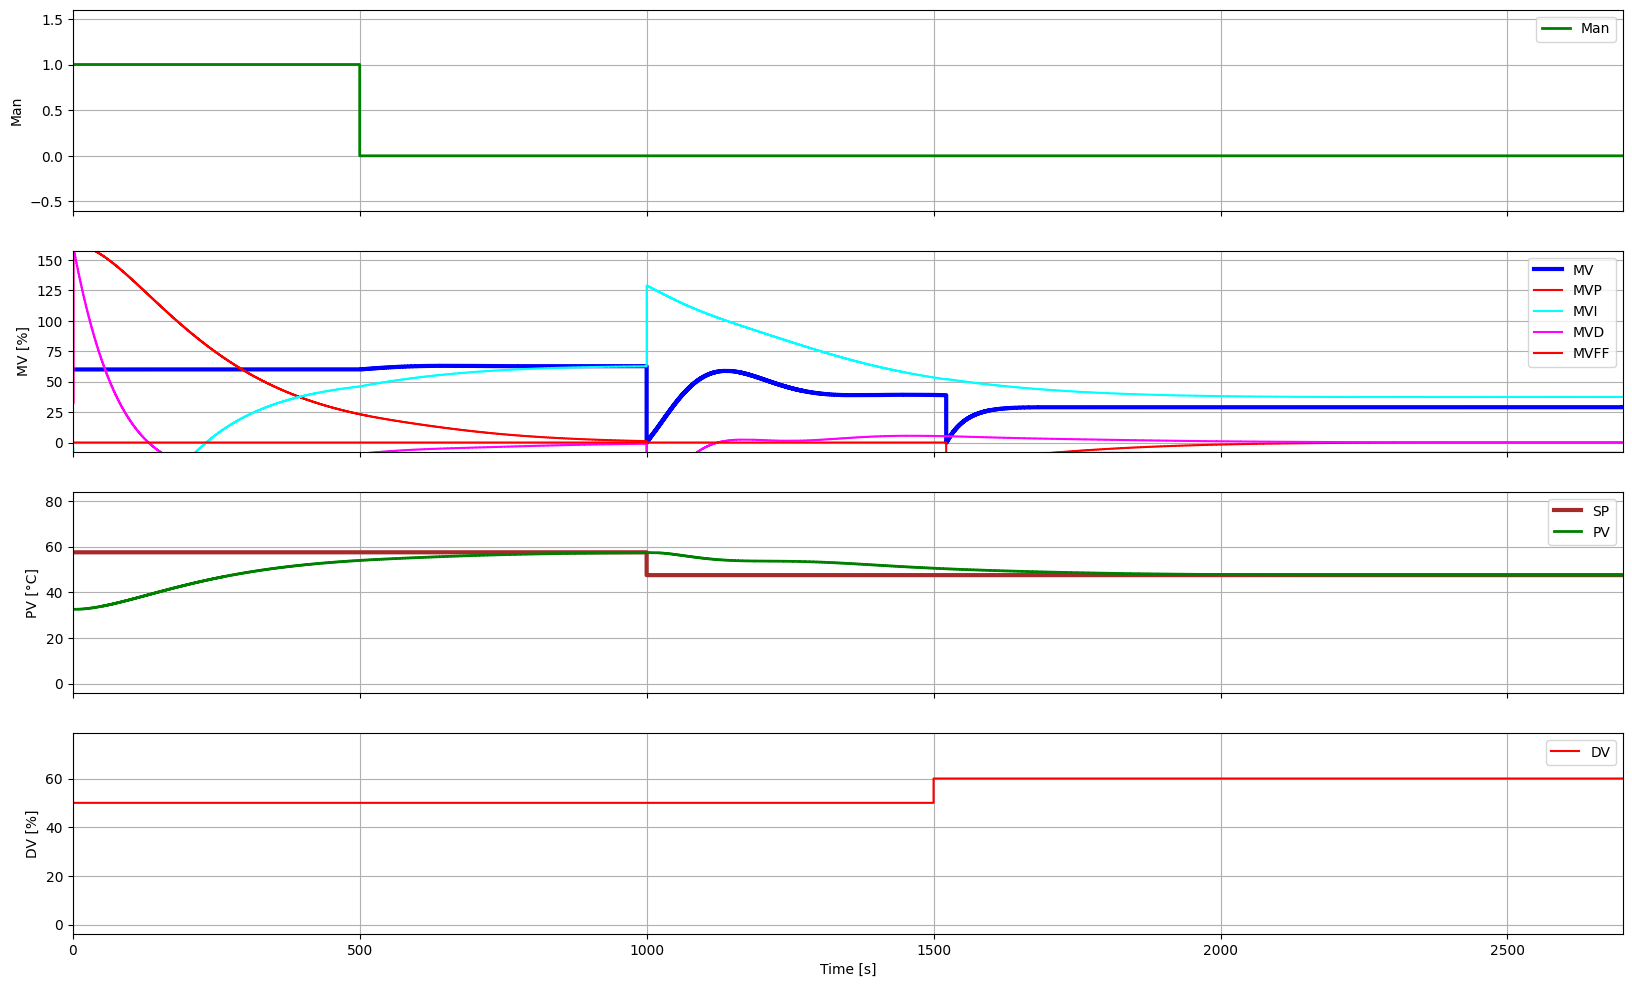

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,ncols=1, sharex='col')
fig.set_figheight(12)
fig.set_figwidth(20)



#------MAN--------
limSup = 1.5
limInf = -0.5
l1, = ax1.step([0,TSim], [limInf,limSup], 'green',linewidth=2, label='Man', where="post")
ax1.set_ylabel('Man')
ax1.legend (loc='best')

#-------MV_MVP_MVI_MVD_MVFF--------------
limSup = 150
limInf = 0
l2, = ax2.step([0, TSim], [limInf,limSup], 'blue', linewidth=3, label='MV', where='post') 
l3, = ax2.step([0, TSim], [limInf,limSup], 'red', label='MVP', where='post') 
l4, = ax2.step([0, TSim], [limInf,limSup], 'cyan', label='MVI', where='post')
l5, = ax2.step([0, TSim], [limInf,limSup], 'magenta', label='MVD', where='post')
l6, = ax2.step([0, TSim], [limInf,limSup], 'red', label='MVFF', where='post') 
ax2.set_ylabel('MV [%]')
ax2.legend (loc='best')


#----SP_and_PV---------
limSup = 80
limInf = 30
l7, = ax3.step([0, TSim], [limInf,limSup], 'brown', linewidth=3, label='SP', where="post")
l8, = ax3.step([0, TSim], [limInf,limSup], 'green', linewidth=2, label='PV', where='post')
ax3.set_ylabel('PV [°C]')
ax3.legend (loc='best')

#-------DV-------------
limSup=75
limInf = 40
l9, = ax4.step([0, TSim], [limInf,limSup], 'red', label='DV', where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('DV [%]')
ax4.legend (loc='best')


#-----Set Data-----
l1.set_data(t, Man)
l2.set_data(t,MV)
l3.set_data(t, MVP)
l4.set_data(t,MVI)
l5.set_data(t, MVD)
l6.set_data(t, MVFF)
l7.set_data(t, SP)
l8.set_data(t, PV)
l9.set_data(t, DV)

tMax = len(t)
ax1.set_xlim(0, tMax)
ax2.set_xlim(0, tMax)
ax3.set_xlim(0, tMax)
ax4.set_xlim(0, tMax)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

